#### Подключаем модули

In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize, Resize
from PIL import Image
import matplotlib.pyplot as plt

#### Подключаем файл из папки "animal-data"

In [2]:
import sys
sys.path.append('../animal-data')
import translate as tr

#### Создадим csv-файл аннотацию к данным

In [3]:
def CreateAnnotations(folder="animal-data"):
    images = []
    keys = []
    for idx, key in enumerate(tr.forward_translate):
        images.append(os.listdir("../"+folder+"/raw-img/"+key))
        keys.append([idx for _ in range(len(images[idx]))])
    series = (  [item for sublist in images for item in sublist],
                [item for sublist in keys for item in sublist])
    pd_dataframe = pd.DataFrame(data=series).transpose()
    pd_dataframe = pd_dataframe.sample(frac=1)
    # 19 650 для обучающей выборки, остальные для тестовой
    pd_dataframe[:19651].to_csv("../"+folder+"/train-annotation.csv", index=False, header=False)
    pd_dataframe[19651:].to_csv("../"+folder+"/test-annotation.csv", index=False, header=False)

CreateAnnotations()

#### Создаём класс датасет

In [4]:
# Создаём собственный датасет из загруженных в отдельную папку данных
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, tr.reverse_translate[tr.labels_map[label]]+"/"+self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = ConvertImageDtype(torch.float32).forward(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def show_example(self, idx=0):
        img, label = self.__getitem__(idx)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(tr.labels_map[label])

#### Загружаем датасет

In [5]:
folder = "../animal-data/"
transform_compose = Compose([ToTensor(), Normalize(mean=[0.5, 0.5, 0.5],std=[0.3, 0.3, 0.3]), Resize([300, 300])])
training_dataset = CustomImageDataset(folder+"train-annotation.csv", folder+"raw-img/", transform=transform_compose)
testing_dataset = CustomImageDataset(folder+"test-annotation.csv", folder+"raw-img/", transform=Compose([ToTensor(), Resize([300, 300])]))

#### Проверяем датасет

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


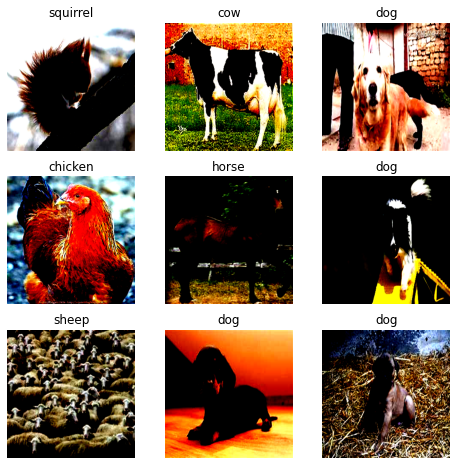

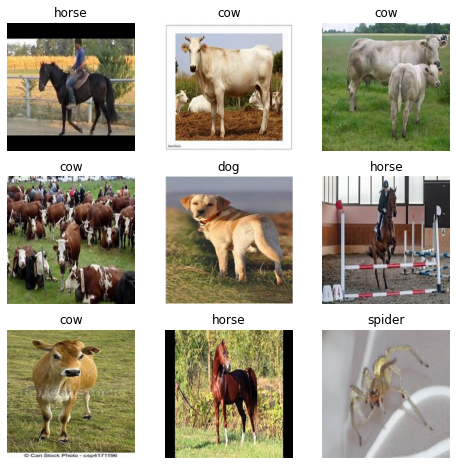

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(tr.labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testing_dataset), size=(1,)).item()
    img, label = testing_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(tr.labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

#### Создаём класс нейронной сети

In [7]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=15, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(20, 2),
            nn.Conv2d(3, 3, 20, 2, 0),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Conv2d(3, 1, 2, 5),
            nn.Dropout(),
            nn.Linear(12, 10),
            nn.Flatten(),
            nn.Softmax(dim=1)
        )
    
    def forward(self, X):
        logits = self.stack(X)
        return logits

#### Задаём необходимые гиперпараметры и алгоритмы обучения

In [8]:
EPOCHS = 2
BATCH_SIZE =512
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999))
loss_function = nn.CrossEntropyLoss()

#### Готовим данные для обучения с помощью DataLoader

In [9]:
train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Обучаем нейронную сеть

In [10]:
def train(dataloader, model, loss_function, optimizer):
    for epoch in range(EPOCHS):
        model.train()
        size = len(dataloader.dataset)
        for i, (batch, labels) in enumerate(dataloader):
            loss = torch.tensor(0, dtype=torch.float32)
            batch, labels = batch.to(device), labels.to(device)
            pred = model(batch)
            loss = loss_function(pred, labels)
            # Обратное распространение ошибки
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                loss, current = loss.item(), i * len(batch)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

train(train_dataloader, model, loss_function, optimizer)

loss: 4.787623  [    0/19650]
loss: 4.769406  [    0/19650]


#### Тестируем нейронную сеть

In [11]:
def test(dataloader, model, loss_function):
    for epoch in range(EPOCHS):
        model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device)
                pred = model(batch)
                test_loss += loss_function(pred, labels).item()
                correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test(test_dataloader, model, loss_function)

Test Error: 
 Accuracy: 6.0%, Avg loss: 4.765274 

Test Error: 
 Accuracy: 6.0%, Avg loss: 4.765336 

